In [2]:
import numpy as np
import pandas as pd
import joblib
import os
import sys
from pathlib import Path
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))
    
from src.data.save_results import save_model_scores, save_model_predictions
from src.utils.data_loader import load_preprocessed_data

import matplotlib.pyplot as plt


In [3]:
 
DATA = path / "data"
TRAINED_DATA = DATA / "trained_data"
MODELS = DATA / "models"
METHOD = "SingleOutput"

In [ ]:
# Define multiple scorings
cv_scorings = {
    "CV RMSE": "neg_root_mean_squared_error",
    "CV MAE": "neg_mean_absolute_error",
    "CV R2": "r2"
}

target_variables = [
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "wind_speed_10m",
    "wind_direction_10m_sin",
    "wind_direction_10m_cos",
    "rain",
    "shortwave_radiation"
]

for target_variable in target_variables:
    data = load_preprocessed_data(method=METHOD, target_variable=target_variable)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    lr_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ])

    tscv = TimeSeriesSplit(n_splits=5)

    # Dictionary to store CV results
    cv_results = {}

    for name, scoring in cv_scorings.items():
        scores = cross_val_score(
            lr_pipeline, X_train, y_train,
            cv=tscv, scoring=scoring
        )
        mean_score = -np.mean(scores) if "neg_" in scoring else np.mean(scores)
        std_score = np.std(scores)
        cv_results[name] = (mean_score, std_score)

    MODEL_PATH = MODELS / "LinearRegression"
    if not MODEL_PATH.exists():
        MODEL_PATH.mkdir(parents=True, exist_ok=True)
    MODEL_TARGET_PATH = MODEL_PATH / f"LR_{target_variable}.pkl"
    if MODEL_TARGET_PATH.exists():
        lr_pipeline = joblib.load(MODEL_TARGET_PATH)
    else:
        # Train and evaluate on test set
        lr_pipeline.fit(X_train, y_train)
        joblib.dump(lr_pipeline, MODEL_TARGET_PATH)
        
    y_pred_lr = lr_pipeline.predict(X_test)

    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    r2_lr = r2_score(y_test, y_pred_lr)

    y_train_pred = lr_pipeline.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)

    # Transform X_train via preprocessor to calculate VIF
    X_train_transformed = preprocessor.fit_transform(X_train)
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()

    X_vif = pd.DataFrame(X_train_transformed)
    vif_data = pd.DataFrame()
    vif_data["feature_index"] = range(X_vif.shape[1])
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

    # === Print results ===
    print(f"[RESULT] Linear Regression - {target_variable}")
    print("Cross-Validation Scores:")
    for name, (mean_score, std_score) in cv_results.items():
        print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")
    print("\nTest Set Evaluation:")
    print(f"  [MAE]: {mae_lr:.2f}")
    print(f"  [RMSE]: {rmse_lr:.2f}")
    print(f"  [Train R2 Score]: {r2_train:.2f}")
    print(f"  [Test R2 Score]: {r2_lr:.2f}")
    print("\n[VIF Scores]")
    print(vif_data.sort_values("VIF", ascending=False).head(20))

    # === Save results ===
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores(
        "LinearRegression",
        PATH,
        mae_lr,
        rmse_lr,
        r2_lr,
        cv_results["CV RMSE"][0],  # mean RMSE
        cv_results["CV RMSE"][1],  # std RMSE
        cv_results["CV MAE"][0],  # mean MAE
        cv_results["CV MAE"][1],  # std MAE
        cv_results["CV R2"][0],  # mean R2
        cv_results["CV R2"][1]  # std R2
    )
    save_model_predictions("LinearRegression", y_test, y_pred_lr, PATH)


[RESULT] Linear Regression - temperature_2m
Cross-Validation Scores:
  [CV RMSE]: 3.18 ± 0.08
  [CV MAE]: 2.49 ± 0.06
  [CV R2]: 0.69 ± 0.00

Test Set Evaluation:
  [MAE]: 2.54
  [RMSE]: 3.22
  [Train R2 Score]: 0.70
  [Test R2 Score]: 0.68

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3               3  2.694716
0               0  2.655588
9               9  2.574975
8               8  2.533521
10             10  2.142527
6               6  2.019605
7               7  1.777153
12             12  1.766127
4               4  1.320416
5               5  1.237504
11             11  1.094703
[RESULT] Linear Regression - apparent_temperature
Cross-Validation Scores:
  [CV RMSE]: 4.62 ± 0.11
  [CV MAE]: 3.64 ± 0.09
  [CV R2]: 0.69 ± 0.00

Test Set Evaluation:
  [MAE]: 3.77
  [RMSE]: 4.75
  [Train R2 Score]: 0.69
  [Test R2 Score]: 0.67

[VIF Scores]
    feature_index       VIF
1               1  3.491729
2               2  2.952208
3       

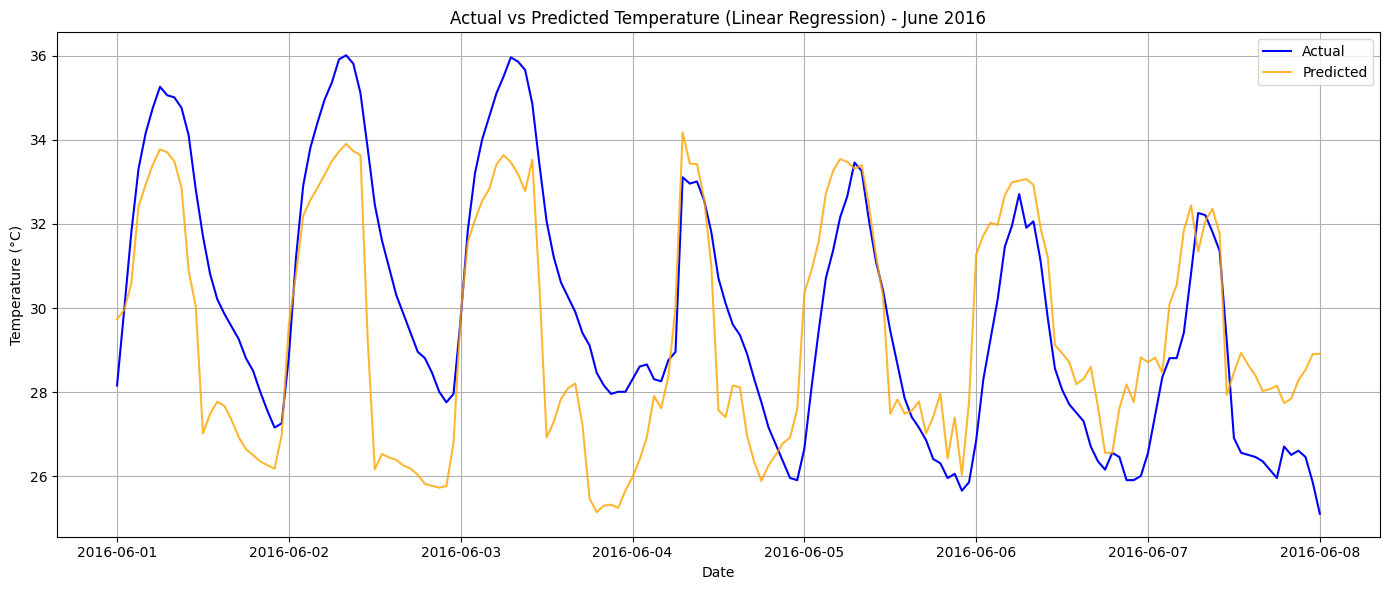

In [ ]:
# Đọc dữ liệu và chuyển đổi cột date
test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/temperature_2m/test_df.csv", parse_dates=["date"])
model_predictions = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/temperature_2m/model_predictions.csv")

# Kiểm tra điều kiện: actual == temperature_2m_max
matching = model_predictions["actual"].values == test_df["temperature_2m"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions["date"] = np.where(
    matching,
    test_df["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions["date"] = pd.to_datetime(model_predictions["date"], errors="coerce")

# Lọc khoảng thời gian từ 01/06/2016 đến 08/06/2016
mask = (model_predictions["date"] >= "2016-06-01") & (model_predictions["date"] <= "2016-06-08")
subset_df = model_predictions[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["LinearRegression_pred"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Linear Regression) - First Week of June 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


[MAE]: 0.23 rad ~ 13.04°
[RMSE]: 0.81 rad ~ 46.63°
[R2]: 0.72


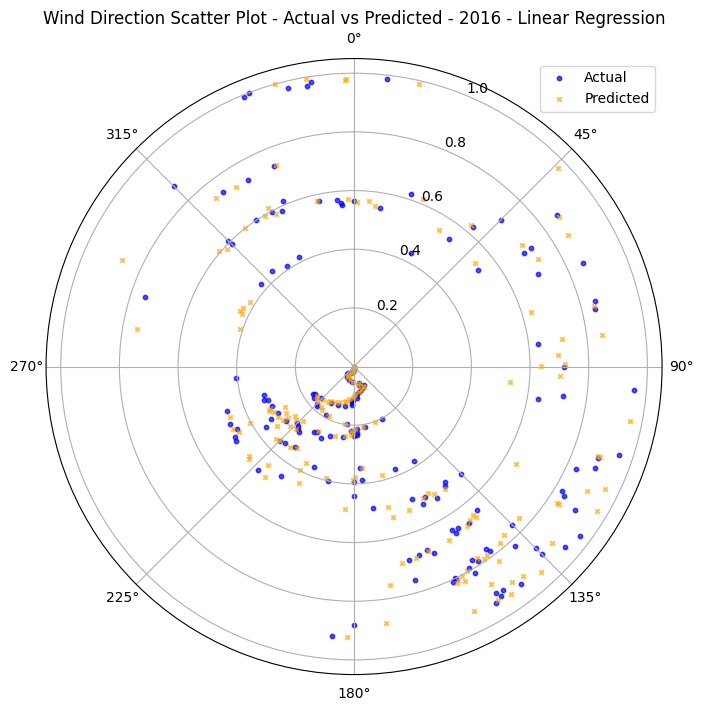

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["LinearRegression_pred"],
                        model_predictions_cos["LinearRegression_pred"])

mae_wind_direction_10m = mean_absolute_error(theta_actual, theta_pred)
rmse_wind_direction_10m = np.sqrt(mean_squared_error(theta_actual, theta_pred))
r2_wind_direction_10m = r2_score(theta_actual, theta_pred)

print(f"[MAE]: {mae_wind_direction_10m:.2f} rad ~ {mae_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[RMSE]: {rmse_wind_direction_10m:.2f} rad ~ {rmse_wind_direction_10m * 180 / np.pi:.2f}°")
print(f"[R2]: {r2_wind_direction_10m:.2f}")

mask = (model_predictions_sin["date"] >= "2016-06-01") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]

r = np.linspace(0, 1, len(theta_actual))

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Linear Regression")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

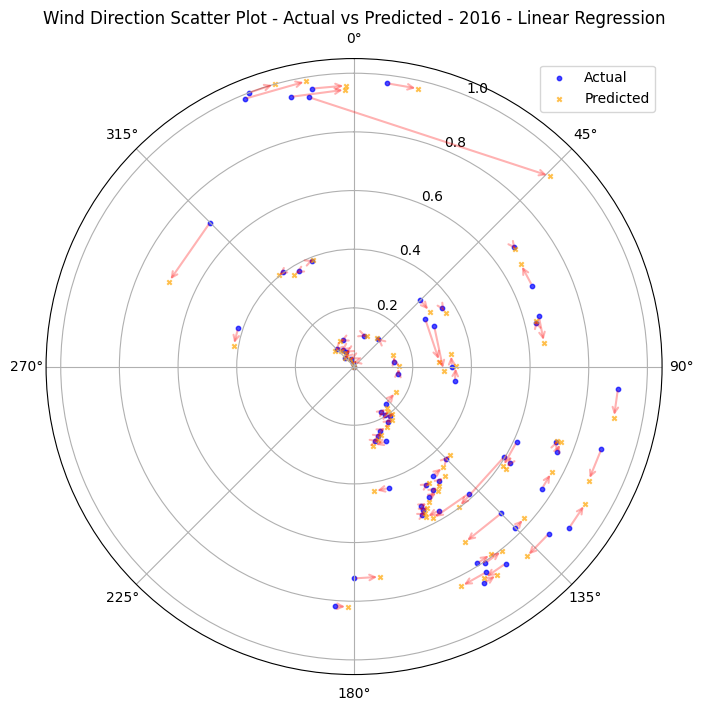

In [7]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

test_df_sin = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_sin/test_df.csv", parse_dates=["date"])
model_predictions_sin = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_sin/model_predictions.csv")

matching = model_predictions_sin["actual"].values == test_df_sin["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_sin["date"] = np.where(
    matching,
    test_df_sin["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_sin["date"] = pd.to_datetime(model_predictions_sin["date"], errors="coerce")

test_df_cos = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/wind_direction_10m_cos/test_df.csv", parse_dates=["date"])
model_predictions_cos = pd.read_csv(f"{DATA}/scores&predictions/{METHOD}/wind_direction_10m_cos/model_predictions.csv")

matching = model_predictions_cos["actual"].values == test_df_cos["wind_direction_10m_sin"].values

# Gán cột 'date' từ test_df nếu giá trị actual khớp
model_predictions_cos["date"] = np.where(
    matching,
    test_df_cos["date"].values,  # nếu khớp, lấy ngày
    pd.NaT                   # nếu không khớp, để giá trị thời gian trống
)
model_predictions_cos["date"] = pd.to_datetime(model_predictions_cos["date"], errors="coerce")

# Chuyển hướng gió sang radian
theta_actual = np.arctan2(model_predictions_sin["actual"], model_predictions_cos["actual"])
theta_pred = np.arctan2(model_predictions_sin["LinearRegression_pred"],
                        model_predictions_cos["LinearRegression_pred"])

mask = (model_predictions_sin["date"] >= "2016-06-05") & (model_predictions_sin["date"] <= "2016-06-08")
theta_actual = theta_actual[mask]
theta_pred = theta_pred[mask]

# Bán kính dàn trải đều
r = np.linspace(0, 1, len(theta_actual))

# Thêm mũi tên nối giữa actual và predicted
for actual, pred, radius in zip(theta_actual, theta_pred, r):
    ax.annotate(
        '',
        xy=(pred, radius),          # Điểm kết thúc (predicted)
        xytext=(actual, radius),    # Điểm bắt đầu (actual)
        arrowprops=dict(
            arrowstyle='->', 
            color='red',
            alpha=0.3,
            lw=1.5
        )
    )

# Vẽ scatter
plt.scatter(theta_actual, r, c='blue', s=10, label="Actual", alpha=0.7)
plt.scatter(theta_pred, r, c='orange', s=10, label="Predicted", alpha=0.7, marker='x')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title("Wind Direction Scatter Plot - Actual vs Predicted - 2016 - Linear Regression")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
METHOD = "MultiOutput"

# Define multiple scorings
cv_scorings = {
    "CV RMSE": "neg_root_mean_squared_error",
    "CV MAE": "neg_mean_absolute_error",
    "CV R2": "r2"
}

target_variables = [
    "temperature_2m",
    "apparent_temperature",
    "relative_humidity_2m",
    "wind_speed_10m",
    "wind_direction_10m_sin",
    "wind_direction_10m_cos",
    "rain",
    "shortwave_radiation"
]

data = load_preprocessed_data(method=METHOD)

X_train = data["X_train"]
X_test_selected = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]
preprocessor = data["preprocessor"]

lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store CV results
cv_results = {}

for name, scoring in cv_scorings.items():
    scores = cross_val_score(
        lr_pipeline, X_train, y_train,
        cv=tscv, scoring=scoring
    )
    mean_score = -np.mean(scores) if "neg_" in scoring else np.mean(scores)
    std_score = np.std(scores)
    cv_results[name] = (mean_score, std_score)

# Train and evaluate on test set
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test_selected)

mae_each = mean_absolute_error(y_test, y_pred_lr, multioutput='raw_values')
rmse_each = np.sqrt(mean_squared_error(y_test, y_pred_lr, multioutput='raw_values'))
r2_each = r2_score(y_test, y_pred_lr, multioutput='raw_values')

y_train_pred = lr_pipeline.predict(X_train)
r2_train_each = r2_score(y_train, y_train_pred, multioutput='raw_values')

# Transform X_train via preprocessor to calculate VIF
# X_train_transformed = preprocessor.fit_transform(X_train)
# if hasattr(X_train_transformed, "toarray"):
#     X_train_transformed = X_train_transformed.toarray()

# X_vif = pd.DataFrame(X_train_transformed)
# vif_data = pd.DataFrame()
# vif_data["feature_index"] = range(X_vif.shape[1])
# vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# === Print results ===
print(f"[RESULT] Linear Regression")
for i, target in enumerate(target_variables):
    print(f"{target}:")
    print("Cross-Validation Scores:")
    for name, (mean_score, std_score) in cv_results.items():
        print(f"  [{name}]: {mean_score:.2f} ± {std_score:.2f}")
    print("\nTest Set Evaluation:")
    print(f"  [MAE]: {mae_each[i]:.2f}")
    print(f"  [RMSE]: {rmse_each[i]:.2f}")
    print(f"  [Train R2 Score]: {r2_train_each[i]:.2f}")
    print(f"  [Test R2 Score]: {r2_each[i]:.2f}")
    print("------------------------------------------\n")
# print("\n[VIF Scores]")
# print(vif_data.sort_values("VIF", ascending=False).head(20))

# for target_variable in target_variables:
#     # === Save results ===
#     PATH = DATA / "scores&predictions" / METHOD / target_variable
#     save_model_scores(
#         "LinearRegression(LR)",
#         mae_lr,
#         rmse_lr,
#         r2_lr,
#         cv_results["CV RMSE"][0],  # mean RMSE
#         cv_results["CV RMSE"][1],  # std RMSE
#         cv_results["CV MAE"][0],  # mean MAE
#         cv_results["CV MAE"][1],  # std MAE
#         cv_results["CV R2"][0],  # mean R2
#         cv_results["CV R2"][1],  # std R2
#         PATH
#     )
#     save_model_predictions("LinearRegression(LR)", y_test, y_pred_lr, PATH)


[RESULT] Linear Regression
temperature_2m:
Cross-Validation Scores:
  [CV RMSE]: 12.96 ± 0.12
  [CV MAE]: 9.44 ± 0.06
  [CV R2]: 0.87 ± 0.01

Test Set Evaluation:
  [MAE]: 1.82
  [RMSE]: 2.34
  [Train R2 Score]: 0.84
  [Test R2 Score]: 0.83
------------------------------------------

apparent_temperature:
Cross-Validation Scores:
  [CV RMSE]: 12.96 ± 0.12
  [CV MAE]: 9.44 ± 0.06
  [CV R2]: 0.87 ± 0.01

Test Set Evaluation:
  [MAE]: 2.49
  [RMSE]: 3.19
  [Train R2 Score]: 0.86
  [Test R2 Score]: 0.85
------------------------------------------

relative_humidity_2m:
Cross-Validation Scores:
  [CV RMSE]: 12.96 ± 0.12
  [CV MAE]: 9.44 ± 0.06
  [CV R2]: 0.87 ± 0.01

Test Set Evaluation:
  [MAE]: 6.39
  [RMSE]: 8.28
  [Train R2 Score]: 0.67
  [Test R2 Score]: 0.66
------------------------------------------

wind_speed_10m:
Cross-Validation Scores:
  [CV RMSE]: 12.96 ± 0.12
  [CV MAE]: 9.44 ± 0.06
  [CV R2]: 0.87 ± 0.01

Test Set Evaluation:
  [MAE]: 0.89
  [RMSE]: 1.12
  [Train R2 Score]: 0.